# Import libraries necessary

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
# images dimensions, batch size, and epochs
img_height, img_width = 224, 224  
batch_size = 32
epochs = 10

# augments data by adding data rotations, shifts, and flips
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)

# train data generator: 80 percent of data
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',       
    classes=['FAKE', 'REAL'],
    subset='training'
)

# train data generator: 20 percent of data
validation_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['FAKE', 'REAL'],
    subset='validation'
)

# only rescale test data
test_datagen = ImageDataGenerator(rescale=1./255)

# test data generator
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['FAKE', 'REAL']
)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


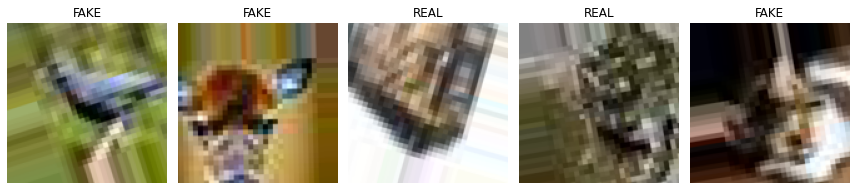

In [17]:
# visualize a random sample of images
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# randomly select samples
sample_batch, sample_labels = next(train_generator)

num_images_to_show = 5

plt.figure(figsize=(12, 3))

for i in range(num_images_to_show):
    img = sample_batch[i]
    label = sample_labels[i]
    
    img_255 = (img * 255).astype("uint8")
    
    # resize image for display
    upscaled_img = Image.fromarray(img_255).resize((128, 128), Image.BICUBIC)

    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(upscaled_img)
    plt.title("FAKE" if label == 0 else "REAL")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
# extract features through VGG-16 pretrained model
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import random
import os

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
feature_extractor = tf.keras.Model(inputs=base_model.input, 
                                   outputs=base_model.layers[-1].output)

import numpy as np

num_batches_to_sample = 5

features_list = []
labels_list = []

# looop over generator to get batches
for i in range(num_batches_to_sample):
    batch_images, batch_labels = next(train_generator)
    
    # preprocess data
    batch_images_preprocessed = preprocess_input(batch_images * 255.0) 

    # extract features
    batch_features = feature_extractor.predict(batch_images_preprocessed)  

    # flatten the features in 1D vector
    batch_features_flat = batch_features.reshape((batch_features.shape[0], -1))  # shape: (batch_size, 7*7*512)

    # append to list
    features_list.append(batch_features_flat)
    labels_list.append(batch_labels)

features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

print("Feature shape:", features.shape)
print("Labels shape:", labels.shape)


Feature shape: (160, 25088)
Labels shape: (160,)


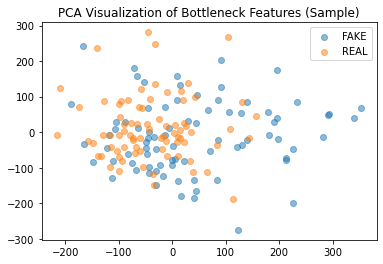

In [9]:
# plotting first 2 principal components
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)  

# Plot the 2D embedding:
plt.scatter(features_pca[labels == 0, 0], features_pca[labels == 0, 1], label='FAKE', alpha=0.5)
plt.scatter(features_pca[labels == 1, 0], features_pca[labels == 1, 1], label='REAL', alpha=0.5)
plt.title("PCA Visualization of Bottleneck Features (Sample)")
plt.legend()
plt.show()

Explained variance ratio by PC1, PC2, PC3: [0.05296427 0.03881229 0.03617186]
Total variance explained by first 3 PCs: 12.79%


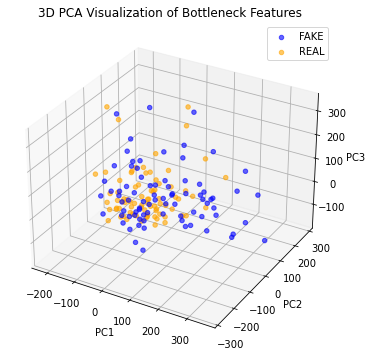

In [10]:
# plotting first 3 principal components
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA with 3 components
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)  

# percentage of variance for first 3 principal components
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio by PC1, PC2, PC3:", explained_variance)
print("Total variance explained by first 3 PCs: {:.2f}%".format(explained_variance.sum() * 100))

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    features_pca[labels == 0, 0],  
    features_pca[labels == 0, 1],  
    features_pca[labels == 0, 2],  
    label='FAKE', alpha=0.6, c='blue'
)
ax.scatter(
    features_pca[labels == 1, 0],
    features_pca[labels == 1, 1],
    features_pca[labels == 1, 2],
    label='REAL', alpha=0.6, c='orange'
)

# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Visualization of Bottleneck Features")
ax.legend()

plt.show()


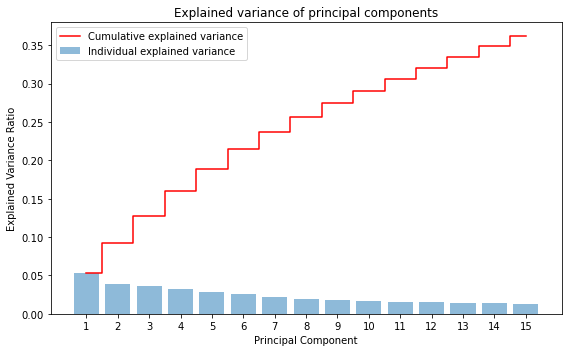

In [16]:
# plot explained variance of principal compnents
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=15)
pca.fit(features)

explained_variance = pca.explained_variance_ratio_

# Plot
plt.figure(figsize=(8, 5))

x = np.arange(1, n_components + 1)
plt.bar(x, explained_variance, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(x, np.cumsum(explained_variance), where='mid',
         label='Cumulative explained variance', color='red')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained variance of principal components')
plt.xticks(x)  
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [22]:
model = Sequential([
    # First convolutional layer with 32 filters
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    
    # Second convolutional layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flatten the feature maps into a 1D vector
    Flatten(),
    
    # Fully connected layer with 128 neurons and dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Output layer: one neuron with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model with binary cross-entropy loss and the Adam optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
# Display the model architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               23888000  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [24]:
# Train the model using the train and validation generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/10
2500/2500 [==============================] - 4029s 2s/step - loss: 0.4917 - accuracy: 0.7769 - val_loss: 0.4784 - val_accuracy: 0.7811
Epoch 2/10
2500/2500 [==============================] - 3180s 1s/step - loss: 0.4047 - accuracy: 0.8241 - val_loss: 0.3955 - val_accuracy: 0.8252
Epoch 3/10
2500/2500 [==============================] - 3125s 1s/step - loss: 0.3536 - accuracy: 0.8502 - val_loss: 0.3275 - val_accuracy: 0.8637
Epoch 4/10
2500/2500 [==============================] - 3201s 1s/step - loss: 0.3289 - accuracy: 0.8614 - val_loss: 0.2963 - val_accuracy: 0.8759
Epoch 5/10
2500/2500 [==============================] - 3261s 1s/step - loss: 0.3086 - accuracy: 0.8723 - val_loss: 0.2715 - val_accuracy: 0.8884
Epoch 6/10
2500/2500 [==============================] - 3153s 1s/step - loss: 0.2913 - accuracy: 0.8817 - val_loss: 0.2728 - val_accuracy: 0.8900
Epoch 7/10
2500/2500 [==============================] - 3115s 1s/step - loss: 0.2834 - accuracy: 0.8851 - val_loss: 0.2551 -

In [25]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

625/625 [==============================] - 184s 294ms/step - loss: 0.2385 - accuracy: 0.9096
Test Accuracy: 90.96%
